## Import library 

In [222]:
import random
import os

from xgboost import XGBClassifier
from lightgbm import log_evaluation, early_stopping, LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score , classification_report

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

## Config

In [223]:
class CFG:
    def __init__(self):

        self.seed=777
        self.epochs=200
        self.batch_size=2048
        self.learning_rate=0.0007
        self.input_class=None
        self.output_class=7

        #self.device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

        self.train=pd.read_csv("data/train.csv")
        self.test=pd.read_csv("data/test.csv")
        self.main=pd.read_csv(r"data\\ObesityDataSet.csv")

        self.class_mapping = {
            'Overweight_Level_II': 0,
            'Normal_Weight': 1,
            'Insufficient_Weight': 2,
            'Obesity_Type_III': 3,
            'Obesity_Type_II': 4,
            'Overweight_Level_I': 5,
            'Obesity_Type_I': 6
        }
        
        self.freq_mapping={
            'no': 0,
            'Always': 3,
            'Frequently': 2,
            'Sometimes': 1
        }

        self.transport_mapping = {
            'Bike': 2,
            'Walking': 2,
            'Public_Transportation': 1,
            'Automobile': 0,
            'Motorbike': 0,
        }

config=CFG()

## Load data


- id : 各個人の一意の識別子
- 性別 : 個人が男性か女性かを示します。
- 年齢 : 個人の年齢
- 身長 : センチメートル単位の個人の身長
- 体重 : 個人の体重 (キログラム)
- family_history_with_overweight : 個人に肥満の家族歴があるかどうかを示します。
- FAVC : 高カロリー食品の摂取頻度
- FCVC : 野菜の摂取頻度
- NCP : 主食の数
- CAEC : 間食の摂取
- SMOKE : 喫煙状態
- CH2O : 1 日あたりの水の消費量
- SCC : カロリー消費モニタリング
- FAF : 身体活動の頻度
- TUE : テクノロジーデバイスの使用時間
- CALC : アルコールの摂取量
- MTRANS : 利用した交通機関


In [224]:
train=config.train.drop("id",axis=1)
test=config.test.drop("id",axis=1)
main=config.main
print(train.shape,main.shape)
# X_train=train.drop("NObeyesdad",axis=1)
# y_train=train["NObeyesdad"]
# train.head()

(20758, 17) (2111, 17)


In [225]:
train=pd.concat([train,main],axis=0)
train.shape

(22869, 17)

In [226]:
print(train.duplicated().sum())
train = train.drop_duplicates()

24


In [227]:
data=train.copy()
num=data.select_dtypes(include=["int64","float64"]).columns
col=data.select_dtypes(include=["object"]).columns

In [228]:
print(num)
print(col)

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')
Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')


数値以外の列のユニークな変数を確認

In [229]:
for col in data:
    if data[col].dtype==object:
        unique=data[col].unique()
        print(f"{col} : {unique}")

Gender : ['Male' 'Female']
family_history_with_overweight : ['yes' 'no']
FAVC : ['yes' 'no']
CAEC : ['Sometimes' 'Frequently' 'no' 'Always']
SMOKE : ['no' 'yes']
SCC : ['no' 'yes']
CALC : ['Sometimes' 'no' 'Frequently' 'Always']
MTRANS : ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
NObeyesdad : ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


In [230]:
data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.000000,3.000000,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.000000,3.000000,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.000000,3.000000,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.000000,3.000000,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


オブジェクト -> 数値 

In [231]:
def X_encode(X):
    X["Gender"]=X["Gender"].apply(lambda x:1 if x=="Male" else 0)
    X["family_history_with_overweight"]=X["family_history_with_overweight"].apply(lambda x:1 if x=="yes" else 0)
    X["FAVC"]=X["FAVC"].apply(lambda x:1 if x=="yes" else 0)
    X["SMOKE"]=X["SMOKE"].apply(lambda x:1 if x=="yes" else 0)
    X["SCC"]=X["SCC"].apply(lambda x:1 if x=="yes" else 0)
    X["CAEC"]=X["CAEC"].map(config.freq_mapping)
    X["CALC"]=X["CALC"].map(config.freq_mapping)
    X["MTRANS"]=X["MTRANS"].map(config.transport_mapping)
    X["NObeyesdad"]=X["NObeyesdad"].map(config.class_mapping).astype(float)
    return X

data=X_encode(data)
data.dtypes

Gender                              int64
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight      int64
FAVC                                int64
FCVC                              float64
NCP                               float64
CAEC                                int64
SMOKE                               int64
CH2O                              float64
SCC                                 int64
FAF                               float64
TUE                               float64
CALC                                int64
MTRANS                              int64
NObeyesdad                        float64
dtype: object

In [232]:
data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,1,0,2.763573,0,0.000000,0.976473,1,1,0.0
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2,0,2.000000,0,1.000000,1.000000,0,0,1.0
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1,0,1.910378,0,0.866045,1.673584,0,1,2.0
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1,0,1.674061,0,1.467863,0.780199,1,1,3.0
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1,0,1.979848,0,1.967973,0.931721,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.000000,3.000000,1,0,1.728139,0,1.676269,0.906247,1,1,3.0
2107,0,21.982942,1.748584,133.742943,1,1,3.000000,3.000000,1,0,2.005130,0,1.341390,0.599270,1,1,3.0
2108,0,22.524036,1.752206,133.689352,1,1,3.000000,3.000000,1,0,2.054193,0,1.414209,0.646288,1,1,3.0
2109,0,24.361936,1.739450,133.346641,1,1,3.000000,3.000000,1,0,2.852339,0,1.139107,0.586035,1,1,3.0


In [233]:
# def feature_eng(df):
#     df['Height_Weight'] = df['Weight'] * df['Height']
#     df['Weight_per_Height'] = df['Weight'] / df['Height']
#     df['Weight_per_Height'] = df['Weight'] / (df['Height')**2]
#     df['Height_per_Weight'] = df['Height'] / df['Weight']
#     df['Weight_per_Age'] = df['Weight'] / df['Age']
#     df['Weight_Age'] = df['Weight'] * df['Age']
#     df['Height_per_Age'] = df['Height'] / df['Age']
#     df['Height_Age'] = df['Height'] * df['Age']
    
#     return df

In [234]:
X=data.drop("NObeyesdad",axis=1)
y=data["NObeyesdad"]
num = X.select_dtypes(include=['int64', 'float64']).columns
col = X.select_dtypes(include=['object']).columns
print(num)
print(col)

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS'],
      dtype='object')
Index([], dtype='object')


In [235]:
X["BMI"]=X["Weight"]/(X["Height"]**2)
X["all_eat"]=X["NCP"]+X["CAEC"]
X["Active"]=X["FAF"]*2+X["MTRANS"]

int , bool -> float

In [236]:
X=X.astype(float)
column_X=X.columns
X.dtypes

Gender                            float64
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight    float64
FAVC                              float64
FCVC                              float64
NCP                               float64
CAEC                              float64
SMOKE                             float64
CH2O                              float64
SCC                               float64
FAF                               float64
TUE                               float64
CALC                              float64
MTRANS                            float64
BMI                               float64
all_eat                           float64
Active                            float64
dtype: object

In [237]:
config.input_class=len(X.columns)
config.input_class

19

## Feature engineering

In [238]:
# 標準化
# def norm(row):
#     min_val=row.min()
#     max_val=row.max()
#     return (row-min_val)/(max_val-min_val)

# for col in X:
#     X[col]=norm(X[col])

# 標準化
# scaler=StandardScaler()
# scaler.fit(X)
# 前者は各列に対しての標準化、後者はデータ全体に対しての標準化

In [239]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])
preprocessor=ColumnTransformer(
    transformers=[
        ("num",numerical_transformer,num)
    ]
)

In [240]:
X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,all_eat,Active
0,1.0,24.443011,1.699998,81.669950,1.0,1.0,2.000000,2.983297,1.0,0.0,2.763573,0.0,0.000000,0.976473,1.0,1.0,28.259565,3.983297,1.000000
1,0.0,18.000000,1.560000,57.000000,1.0,1.0,2.000000,3.000000,2.0,0.0,2.000000,0.0,1.000000,1.000000,0.0,0.0,23.422091,5.000000,2.000000
2,0.0,18.000000,1.711460,50.165754,1.0,1.0,1.880534,1.411685,1.0,0.0,1.910378,0.0,0.866045,1.673584,0.0,1.0,17.126706,2.411685,2.732090
3,0.0,20.952737,1.710730,131.274851,1.0,1.0,3.000000,3.000000,1.0,0.0,1.674061,0.0,1.467863,0.780199,1.0,1.0,44.855798,4.000000,3.935726
4,1.0,31.641081,1.914186,93.798055,1.0,1.0,2.679664,1.971472,1.0,0.0,1.979848,0.0,1.967973,0.931721,1.0,1.0,25.599151,2.971472,4.935946


# Find best hyper_param

In [241]:
%timeit
folds=StratifiedKFold(n_splits=30,random_state=config.seed,shuffle=True)

def cross_val_score(estimator, X, y, cv = folds, show_importance=False):
    train_scores , val_scores = [], []
    
    if show_importance:
        feature_importances_table = pd.DataFrame({'value': 0}, index=list(X.columns))

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        model = clone(estimator)

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        val_preds = model.predict(X_val)
        train_preds = model.predict(X_train)

        if show_importance:
            feature_importances_table['value'] += permutation_importance(
                model, X_val, y_val, scoring='accuracy', n_repeats=5).importances_mean

        # Evaluate model for a fold
        val_score = accuracy_score(y_val, val_preds)
        val_scores.append(val_score)
        train_score = accuracy_score(y_train, train_preds)
        train_scores.append(train_score)

    if show_importance:
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importance - Mean Accuracy: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f}', size=15, weight='bold')
        sns.barplot(feature_importances_table.sort_values('value', ascending=False).T, orient='h', palette='viridis')
        plt.show()
    else:
        print(f'Mean Validation Accuracy: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f}')
        print(f'Mean Training Accuracy: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f}')

    return np.mean(val_scores)

# Transfer data 

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=config.seed)

In [243]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

18276
18276
4569
4569


## Model

# Catboost

In [244]:
# def objective(trial):
#     iterations = trial.suggest_int('iterations', 25, 1000, step=10)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
#     depth = trial.suggest_int('depth', 1, 15)
#     l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 1)
#     bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'Poisson'])
#     subsample = trial.suggest_float('subsample', 0.1, 1.0)

#     model = CatBoostClassifier(
#         iterations=iterations,
#         learning_rate=learning_rate,
#         depth=depth,
#         l2_leaf_reg=l2_leaf_reg,
#         bootstrap_type=bootstrap_type,
#         subsample=subsample,
#         random_state=config.seed,
#         verbose=0,  # Set verbose to 0 to suppress CatBoost output
#         metric_period=1,
#         eval_metric="Accuracy",
#         task_type="GPU",
#         devices='0:1'
#     )
    
#     pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
#     # Train the model
#     acc = cross_val_score(pipeline,X ,y)
    
#     return acc

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

In [245]:
# hyperparameters = {
#     'iterations': 385,
#     'learning_rate': 0.2326523033314959,
#     'depth': 5,
#     'l2_leaf_reg': 0.36631694999249886,
#     'bootstrap_type': 'Bernoulli',
#     'subsample': 0.6692572640982412
# }

# # ファイル名を指定します
# file_name = "hypara_catboost.txt"

# # テキストファイルに書き込みます
# with open(file_name, 'w') as file:
#     for key, value in hyperparameters.items():
#         file.write(f"{key}: {value}\n")


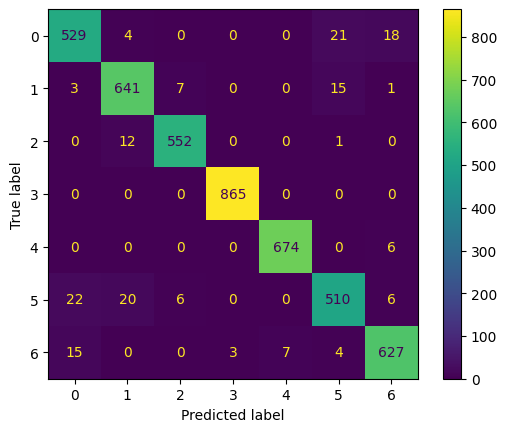

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93       572
         1.0       0.95      0.96      0.95       667
         2.0       0.98      0.98      0.98       565
         3.0       1.00      1.00      1.00       865
         4.0       0.99      0.99      0.99       680
         5.0       0.93      0.90      0.91       564
         6.0       0.95      0.96      0.95       656

    accuracy                           0.96      4569
   macro avg       0.96      0.96      0.96      4569
weighted avg       0.96      0.96      0.96      4569



0.9625738673670388

In [246]:
best_model=CatBoostClassifier(**{
     'iterations': 385,
     'learning_rate': 0.2326523033314959,
     'depth': 5,
     'l2_leaf_reg': 0.36631694999249886,
     'bootstrap_type': 'Bernoulli',
     'subsample': 0.6692572640982412,
     "random_state":config.seed,
     "verbose":0,
     "metric_period":1,
     "eval_metric":"Accuracy",
     "task_type":"GPU",
     "devices":"0:1"
 })

Cat_best=Pipeline(steps=[("preprocessor",preprocessor),("model",best_model)])
Cat_best.fit(X,y)

pred=Cat_best.predict(X_test)

acc=accuracy_score(y_test,pred)

cm=confusion_matrix(y_test,pred)

disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test,pred))

acc

# LightGBM

In [247]:
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 1000, step=10)
#     learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.5)
#     max_depth = trial.suggest_int('max_depth', 3, 15)
#     min_child_samples = trial.suggest_int('min_child_samples', 1, 20)
#     subsample = trial.suggest_float('subsample', 0.5, 1.0)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
#     num_leaves = trial.suggest_int('num_leaves', 2, 10)

#     model = LGBMClassifier(
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         min_child_samples=min_child_samples,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         num_leaves = num_leaves,
#         random_state=config.seed
#     )

#     pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
#     # Train the model
#     acc = cross_val_score(pipeline,X ,y)
    
#     return acc

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

In [248]:
# hyperparameters= {'n_estimators': 380, 
#                   'learning_rate': 0.05558080757136064, 
#                   'max_depth': 4, 
#                   'min_child_samples': 11, 
#                   'subsample': 0.9401530463723002,
#                   'colsample_bytree': 0.5018302946163034, 
#                   'num_leaves': 10}

# # ファイル名を指定します
# file_name = "hypara_lightGBM.txt"

# # テキストファイルに書き込みます
# with open(file_name, 'w') as file:
#     for key, value in hyperparameters.items():
#         file.write(f"{key}: {value}\n")

[LightGBM] [Warning] Unknown parameter: pgu_platform_id
[LightGBM] [Warning] Unknown parameter: pgu_platform_id
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

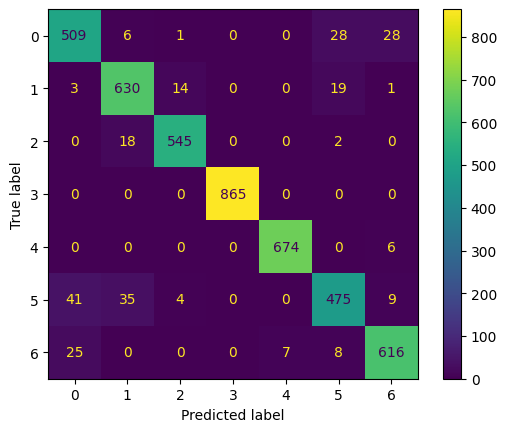

              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       572
         1.0       0.91      0.94      0.93       667
         2.0       0.97      0.96      0.97       565
         3.0       1.00      1.00      1.00       865
         4.0       0.99      0.99      0.99       680
         5.0       0.89      0.84      0.87       564
         6.0       0.93      0.94      0.94       656

    accuracy                           0.94      4569
   macro avg       0.94      0.94      0.94      4569
weighted avg       0.94      0.94      0.94      4569



0.9441891004596191

In [249]:
best_model = LGBMClassifier(**{
                'n_estimators': 380, 
                'learning_rate': 0.05558080757136064, 
                'max_depth': 4, 
                'min_child_samples': 11, 
                'subsample': 0.9401530463723002,
                'colsample_bytree': 0.5018302946163034, 
                "objective":"multiclass",
                'num_leaves': 10,
                "random_state":config.seed,
                "boosting_type":"gbdt",
                "verbose":0,
                "metric":"multi_logloss",
                "device":"gpu",
                "pgu_platform_id":0,
                "gpu_device_id":0
    })

LGBM_best = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])

LGBM_best.fit(X,y)

pred=LGBM_best.predict(X_test)

acc=accuracy_score(y_test,pred)

cm=confusion_matrix(y_test,pred)

disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test,pred))


acc

# Xgboost

In [250]:
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 25, 1000, step=5)
#     learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.5)
#     max_depth = trial.suggest_int('max_depth', 3, 15)
#     min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
#     gamma = trial.suggest_loguniform('gamma', 1e-3, 1)
#     reg_lambda = trial.suggest_float('reg_lambda', .01, 20, log = True)
#     reg_alpha = trial.suggest_float('reg_alpha', .01, 10, log = True)
#     eta = trial.suggest_float('eta', .001, .3, log = True)
#     subsample = trial.suggest_float('subsample', .5, 1)
#     colsample_bytree = trial.suggest_float('colsample_bytree', .1, 1)

#     model = XGBClassifier(
#       n_estimators=n_estimators,
#       learning_rate=learning_rate,
#       max_depth=max_depth,
#       min_child_weight=min_child_weight,
#       gamma=gamma,
#       reg_lambda = reg_lambda,
#       reg_alpha = reg_alpha,
#       eta = eta,
#       subsample = subsample,
#       colsample_bytree = colsample_bytree,
#       tree_method= 'hist',
#        device = 'cuda',
#        objective='multi:softmax',
#        eval_metric= 'auc',
#        random_state=42
#       )
    
    # pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
#     # Train the model
#     acc = cross_val_score(pipeline,X ,y)
    
#     return acc

# # Create a study object and optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

In [251]:
# hyperparameters={'n_estimators': 730, 
#                  'learning_rate': 0.05282226968718004, 
#                  'max_depth': 12, 
#                  'min_child_weight': 2, 
#                  'gamma': 0.0010809016336985886, 
#                  'reg_lambda': 3.8235771373783325, 
#                  'reg_alpha': 3.2748718538219097, 
#                  'eta': 0.02664069309030444, 
#                  'subsample': 0.5604379743081558, 
#                  'colsample_bytree': 0.3714054959064784}

# # ファイル名を指定します
# file_name = "hypara_xgboost.txt"

# # テキストファイルに書き込みます
# with open(file_name, 'w') as file:
#     for key, value in hyperparameters.items():
#         file.write(f"{key}: {value}\n")

c:\Users\morik\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


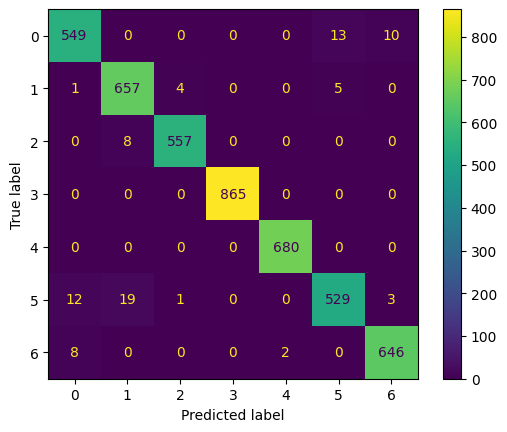

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       572
         1.0       0.96      0.99      0.97       667
         2.0       0.99      0.99      0.99       565
         3.0       1.00      1.00      1.00       865
         4.0       1.00      1.00      1.00       680
         5.0       0.97      0.94      0.95       564
         6.0       0.98      0.98      0.98       656

    accuracy                           0.98      4569
   macro avg       0.98      0.98      0.98      4569
weighted avg       0.98      0.98      0.98      4569



0.9811775005471657

In [252]:
best_model = XGBClassifier({
                'n_estimators': 730, 
                'learning_rate': 0.05282226968718004, 
                'max_depth': 12, 
                'min_child_weight': 2, 
                'gamma': 0.0010809016336985886, 
                'reg_lambda': 3.8235771373783325, 
                'reg_alpha': 3.2748718538219097, 
                'eta': 0.02664069309030444, 
                'subsample': 0.5604379743081558, 
                'colsample_bytree': 0.3714054959064784,
                "tree_method":'hist',
                "device":'cuda',
                "objective":'multi:softmax',
                "eval_metric":'auc',
                "random_state":config.seed
                })

XGB_best = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])

XGB_best.fit(X,y)

pred=XGB_best.predict(X_test)

acc=accuracy_score(y_test,pred)

cm=confusion_matrix(y_test,pred)

disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test,pred))

acc

[LightGBM] [Warning] Unknown parameter: pgu_platform_id
[LightGBM] [Warning] Unknown parameter: pgu_platform_id
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

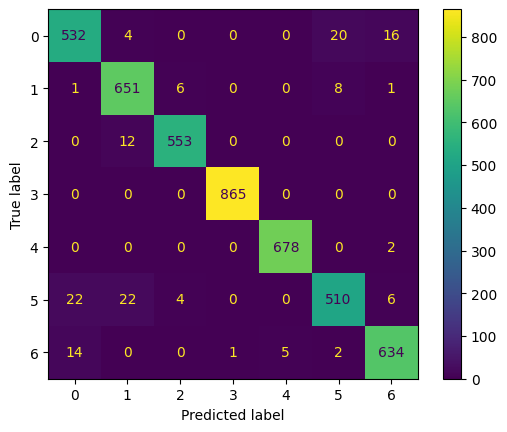

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       572
         1.0       0.94      0.98      0.96       667
         2.0       0.98      0.98      0.98       565
         3.0       1.00      1.00      1.00       865
         4.0       0.99      1.00      0.99       680
         5.0       0.94      0.90      0.92       564
         6.0       0.96      0.97      0.96       656

    accuracy                           0.97      4569
   macro avg       0.97      0.96      0.97      4569
weighted avg       0.97      0.97      0.97      4569



0.9680455241847231

In [253]:
from sklearn.ensemble import VotingClassifier

# # Create a VotingClassifier with the three XGBoost models
voting = VotingClassifier(estimators=[
    ('Model1', LGBM_best),
    ('Model2', XGB_best),
    ('Model3', Cat_best)
], voting='soft')

voting.fit(X, y)

predictions = voting.predict(X_test)

accurate = accuracy_score(y_test, predictions)

cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print(classification_report(y_test, predictions))
    
accurate

# Test

In [254]:
def test_encode(X):
    X["Gender"]=X["Gender"].apply(lambda x:1 if x=="Male" else 0)
    X["family_history_with_overweight"]=X["family_history_with_overweight"].apply(lambda x:1 if x=="yes" else 0)
    X["FAVC"]=X["FAVC"].apply(lambda x:1 if x=="yes" else 0)
    X["SMOKE"]=X["SMOKE"].apply(lambda x:1 if x=="yes" else 0)
    X["SCC"]=X["SCC"].apply(lambda x:1 if x=="yes" else 0)
    X["CAEC"]=X["CAEC"].map(config.freq_mapping)
    X["CALC"]=X["CALC"].map(config.freq_mapping)
    X["MTRANS"]=X["MTRANS"].map(config.transport_mapping)
    #X["NObeyesdad"]=X["NObeyesdad"].map(config.class_mapping).astype(float)
    return X

test=test_encode(test)
test.dtypes

Gender                              int64
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight      int64
FAVC                                int64
FCVC                              float64
NCP                               float64
CAEC                                int64
SMOKE                               int64
CH2O                              float64
SCC                                 int64
FAF                               float64
TUE                               float64
CALC                                int64
MTRANS                              int64
dtype: object

In [255]:
test["BMI"]=test["Weight"]/(test["Height"]**2)
test["all_eat"]=test["NCP"]+test["CAEC"]
test["Active"]=test["FAF"]*2+test["MTRANS"]

In [256]:
test=test.astype(float)
column_X=test.columns
test.dtypes

Gender                            float64
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight    float64
FAVC                              float64
FCVC                              float64
NCP                               float64
CAEC                              float64
SMOKE                             float64
CH2O                              float64
SCC                               float64
FAF                               float64
TUE                               float64
CALC                              float64
MTRANS                            float64
BMI                               float64
all_eat                           float64
Active                            float64
dtype: object

In [257]:
pred = voting.predict(test)

In [258]:
#set(pred)

In [259]:
final_output=pd.concat([pd.DataFrame(config.test["id"]),pd.DataFrame(pred)],axis=1)
final_output.rename(columns={0:"NObeyesdad"},inplace=True)
final_output.head()
final_output

,id,NObeyesdad
0,20758,4.0
1,20759,5.0
2,20760,3.0
3,20761,6.0
4,20762,3.0
...,...,...
13835,34593,0.0
13836,34594,1.0
13837,34595,2.0
13838,34596,1.0


In [260]:
class_mapping_rev = {config.class_mapping[k] : k for k in config.class_mapping}
class_mapping_rev

{0: 'Overweight_Level_II',
 1: 'Normal_Weight',
 2: 'Insufficient_Weight',
 3: 'Obesity_Type_III',
 4: 'Obesity_Type_II',
 5: 'Overweight_Level_I',
 6: 'Obesity_Type_I'}

In [261]:
final_output['NObeyesdad'] = final_output['NObeyesdad'].map(class_mapping_rev)
final_output

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [262]:
final_output.to_csv('submission.csv', index=False)